In [2]:
import pandas
import pymc3 as pm
import warnings
import arviz as az
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
c_obs = 1300
v_obs = 1500
c_conversions = 273
v_conversions = 570


#group A
with pm.Model() as control:
    
    #Prior
    p_A=pm.Beta('Control', alpha = 1, beta= 1)  
    
    #fit the observed data
    obs=pm.Binomial("Observed", n=c_obs, p=p_A, observed=c_conversions)
    
    trace_control = pm.sample(1000)
    

with pm.Model() as variant:
    #Prior
    p_B=pm.Beta('Variant', alpha=1, beta=1)  
    
    #fit the observed data to our model 
    obs=pm.Binomial("Observed", n=v_obs, p=p_B, observed=v_conversions)
    
    trace_variant = pm.sample(1000)
    
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Control]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Variant]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.


<AxesSubplot:title={'center':'Control'}>

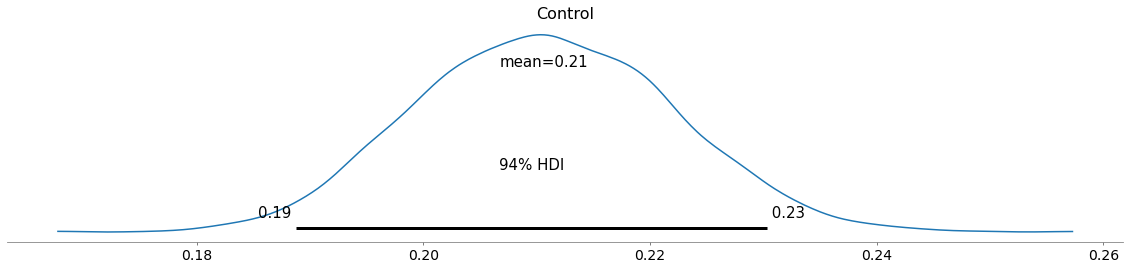

In [4]:

plt.rcParams["figure.figsize"] = (20,4)
az.plot_posterior(trace_control)

In [6]:
samples_posterior_control=trace_control['Control']
samples_posterior_variant=trace_variant['Variant']



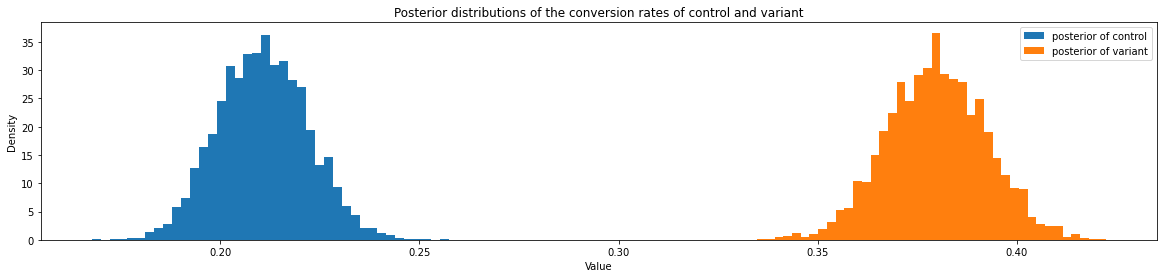

In [7]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (20,4)
plt.hist(samples_posterior_control, bins=40, label='posterior of control', density=True)
plt.hist(samples_posterior_variant, bins=40, label='posterior of variant', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the conversion rates of control and variant")
plt.legend()
plt.show()

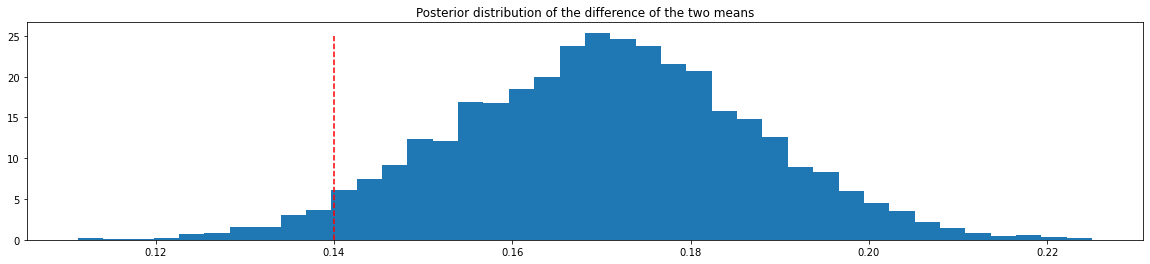

In [15]:
difference=samples_posterior_variant-samples_posterior_control
plt.rcParams["figure.figsize"] = (20,4)
plt.hist(difference, bins=40, density=True)
plt.vlines(0.14, 0, 25, linestyle='--', color='red')
plt.title('Posterior distribution of the difference of the two means')
plt.show()

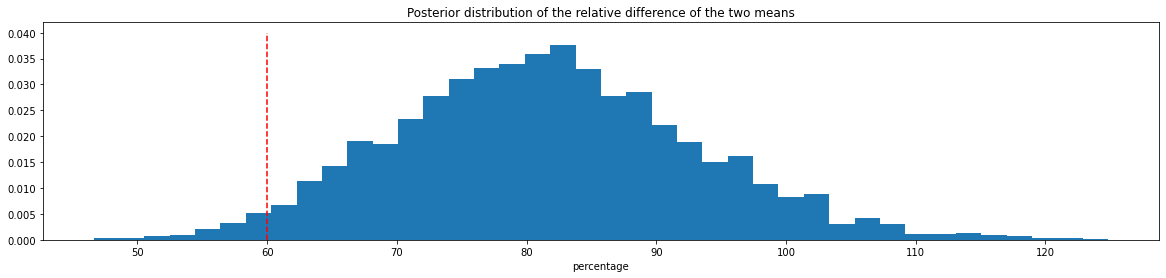

In [17]:
rel_difference=100*(samples_posterior_variant-samples_posterior_control)/samples_posterior_control
plt.rcParams["figure.figsize"] = (20,4)
plt.hist(rel_difference, bins=40, density=True)
plt.vlines(60, 0, 0.04, linestyle='--', color='red')
plt.title('Posterior distribution of the relative difference of the two means')
plt.xlabel("percentage")
plt.show()

In [21]:
100*len(rel_difference[rel_difference>50])*1.0/len(rel_difference)

99.9

In [22]:

print(f'Probability that Variant is better: {(samples_posterior_B > samples_posterior_A).mean():.1%}.')

NameError: name 'samples_posterior_B' is not defined

<AxesSubplot:title={'center':'x'}>

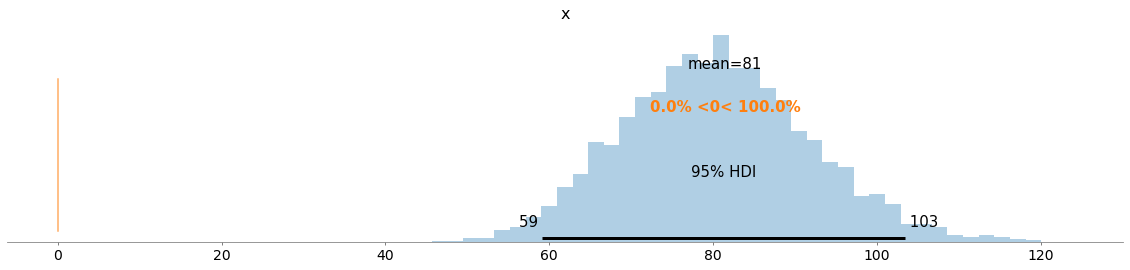

In [23]:

az.plot_posterior(rel_difference, var_names=None, ref_val=0, kind = 'hist', hdi_prob = .95)

In [144]:

def check_significance(data, hdi_prob):
    
    #Not all values of hdi_prob area allowed
    
    
    lower = round(((1-(hdi_prob))/2)*100, 1)
    upper = 100*hdi_prob+lower
    
    summary = az.summary(data, hdi_prob=hdi_prob)
    
    assert summary.columns[2] == 'hdi_{}%'.format(lower)
    assert summary.columns[3] == 'hdi_{}%'.format(upper)
    
    
    print(
        not summary['hdi_{}%'.format(lower)][0] <= 0 <=  summary['hdi_{}%'.format(upper)][0], 
        summary['hdi_{}%'.format(lower)][0],
        summary['hdi_{}%'.format(upper)][0]
    )

    
    


In [143]:
check_significance(rel_difference, hdi_prob)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


True 56.986 106.385


In [106]:
summary = az.summary(rel_difference, hdi_prob = 0.95)

#if 2 in range(summary['hdi_97.5%'][0],  summary['hdi_2.5%'][0]):
#    print('hell0')
    
summary['hdi_97.5%'][0] <= 0 <= summary['hdi_2.5%'][0]
    



arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


False

In [93]:
summary['hdi_97.5%'][0]

103.401